# Compare with Adede State of the Art

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [4]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_TARGET_VAR_our_vars_ALL'
EXPERIMENT =      'one_month_forecast'
# TRUE_EXPERIMENT = 'ICLR_one_month_forecast_BOKU_TARGET_VAR_our_vars_ALL'
TRUE_EXPERIMENT = 'one_month_forecast'

TARGET_VAR =      'boku_VCI'
# TARGET_VAR =      'VCI3M'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'features/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

data/models/one_month_forecast


# Read in the data

### Load in the models

In [5]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [6]:
from src.models import load_model

ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
ealstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

10

In [7]:
dynamic_ds = ds.drop([v for v in ealstm.ignore_vars if v in list(ds.data_vars)])

static_vars_to_include = [
    v
    for v in static_ds.data_vars
    if all([ign_v not in v for ign_v in ealstm.ignore_vars])
]
static = static_ds[static_vars_to_include]

In [8]:
print("TRAINING DATA")
display(ds)
print('\n\n')
print("TARGET DATA")
display(y_test)

TRAINING DATA


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
Data variables:
    boku_VCI    (time, lat, lon) float64 82.14 83.13 71.48 ... 29.12 77.78 49.71
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 4.625 4.678 4.806 4.71 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan




TARGET DATA


<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 36)
Coordinates:
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * lat       (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * time      (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 74.48 83.21 84.39 ... 29.12 77.78 49.71

In [9]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

# bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
# lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

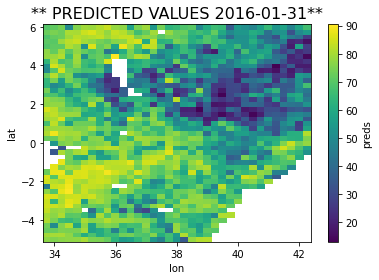

In [10]:
fig, ax = plt.subplots()
time_ix = 0
time = ealstm_pred.isel(time=time_ix).time.values
ealstm_pred.isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]}**", size=16);

# Model information

In [11]:
# print the model training features
ljust = 30

print(
    "", "MODEL NAME: ".ljust(ljust), f"{EXPERIMENT}\n",
    "Target Var: ".ljust(ljust), f"{TARGET_VAR}\n",
    "Normalize y: ".ljust(ljust), f"{ealstm.normalize_y}\n",
    "Train Years: ".ljust(ljust), f"{ds['time.year'].min().values}: {y_train['time.year'].max().values}\n",
    "Test Years: ".ljust(ljust), f"{np.unique(y_test['time.year'])}\n",
#     "N Pixels: ".ljust(ljust), f"{len(df.station_id.unique())}\n",
    "Dynamic Variables: ".ljust(ljust), f"{[v for v in list(ds.data_vars) if v not in list(set(ealstm.ignore_vars))]}\n",
    "Static Variables: ".ljust(ljust), f"{[v for v in list(static_ds.data_vars) if all([i not in v for i in list(set(ealstm.ignore_vars))])]}\n", 
#     "Sequence Length: ".ljust(ljust), f"{ealstm.seq_length}\n", 
    "Final Linear Layer size: ".ljust(ljust), f"{ealstm.dense_features}\n", 
    "Static Embedding Size: ".ljust(ljust), f"{ealstm.static_embedding_size}\n", 
#     "Num Epochs: ".ljust(ljust), f"{N_EPOCHS}\n", 
#     "VAR: ".ljust(ljust), f"{VAR}\n", 
)

 MODEL NAME:                    one_month_forecast
 Target Var:                    boku_VCI
 Normalize y:                   True
 Train Years:                   2001: 2015
 Test Years:                    [2016 2017 2018]
 Dynamic Variables:             ['boku_VCI', 'precip', 'E', 'SMsurf', 'pev']
 Static Variables:              ['precip_global_mean', 'E_global_mean', 'SMsurf_global_mean', 'pev_global_mean', 'precip_pixel_mean', 'E_pixel_mean', 'SMsurf_pixel_mean', 'pev_pixel_mean', 'topography', 'lc_class', 'lc_class_group', 'cropland_rainfed_one_hot', 'herbaceous_cover_one_hot', 'tree_or_shrub_cover_one_hot', 'cropland_irrigated_or_postflooding_one_hot', 'tree_cover_one_hot', 'shrubland_one_hot', 'grassland_one_hot', 'urban_areas_one_hot', 'bare_areas_one_hot', 'water_bodies_one_hot', 'permanent_snow_and_ice_one_hot', 'slt']
 Final Linear Layer size:       [256, 1]
 Static Embedding Size:         64



# Load in model predictions

In [12]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1]# .where(~mask)
lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1]# .where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1]#.where(~mask)
lr_pred = read_pred_data('linear_regression', data_dir, experiment=EXPERIMENT)[-1]#.where(~mask)
ln_pred = read_pred_data('linear_network', data_dir, experiment=EXPERIMENT)[-1]#.where(~mask)

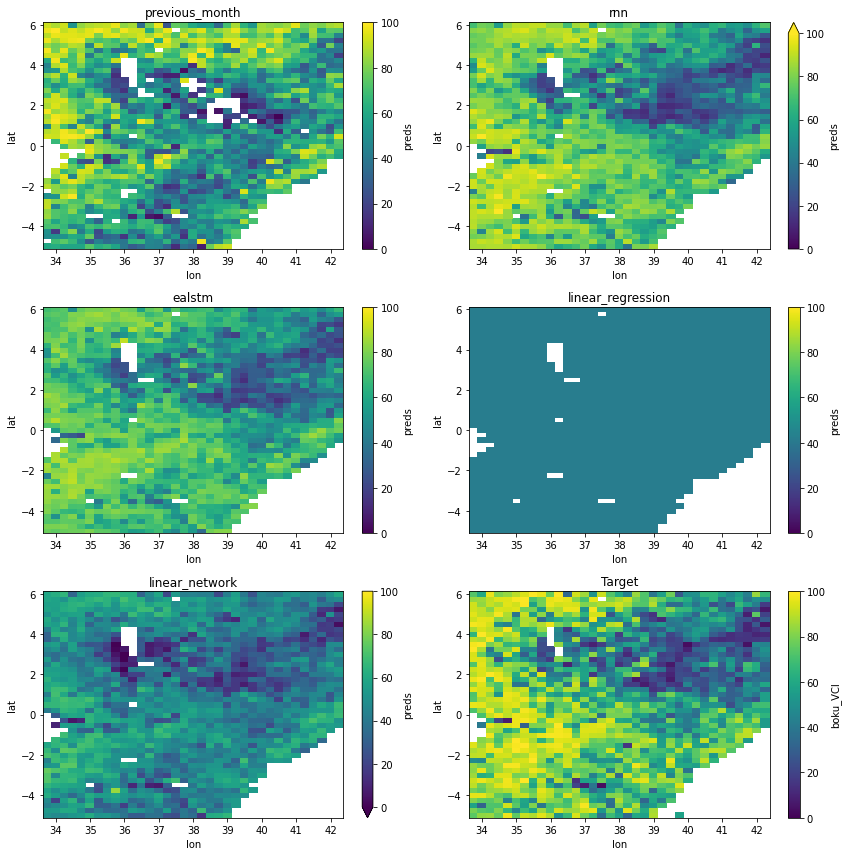

In [13]:
preds_dict = {"previous_month": bline_pred, 
"rnn": lstm_pred, 
"ealstm": ealstm_pred, 
"linear_regression": lr_pred, 
"linear_network": ln_pred}

fig, axs = plt.subplots(3, 2, figsize=(6*2, 4*3))

for ix, (model_name, preds) in enumerate(preds_dict.items()):
    ax = axs[np.unravel_index(ix, (3,2))]
    preds.isel(time=0).plot(ax=ax, vmin=0, vmax=100, cmap='viridis')
    ax.set_title(model_name)


ax = axs[np.unravel_index(5, (3,2))]
y_test[TARGET_VAR].isel(time=0).plot(ax=ax, vmin=0, vmax=100, cmap='viridis')
ax.set_title("Target")
fig.tight_layout()

# DataFrame of Model Performances

In [14]:
from src.analysis import annual_scores

In [15]:
[d.name for d in (data_dir / f"models/{EXPERIMENT}").iterdir()]

['rnn', 'linear_network', 'previous_month', 'ealstm', 'linear_regression']

In [16]:
models = ['ealstm', 'rnn', 'previous_month', 'linear_network', 'linear_regression']

# load the monthly scores dictionary
monthly_scores = annual_scores(
    data_path=data_dir,
    models=models,
    metrics=['rmse', 'r2'],
    pred_years=[y for y in range(2016, 2019)],
    experiment=EXPERIMENT,
    true_data_experiment=TRUE_EXPERIMENT,
    target_var=TARGET_VAR,
    verbose=False,
    to_dataframe=True
)
monthly_scores['time'] = monthly_scores.apply(lambda row: pd.to_datetime(f"{int(row.month)}-{int(row.year)}"), axis=1)
monthly_scores.head()

,month,year,ealstm,rnn,previous_month,linear_network,linear_regression,metric,time
0,1.0,2016.0,13.438398,12.590804,21.886197,25.585350,32.801580,rmse,2016-01-01
1,2.0,2016.0,12.493573,12.581519,21.712380,20.808718,26.914791,rmse,2016-02-01
2,3.0,2016.0,14.505330,14.713287,17.362805,28.726431,24.062409,rmse,2016-03-01
3,4.0,2016.0,12.044819,10.667603,15.724187,14.180259,20.576316,rmse,2016-04-01
4,5.0,2016.0,13.917147,13.281613,17.737472,14.789164,20.688625,rmse,2016-05-01


# Explore Spatial Errors

In [17]:
from src.analysis import spatial_rmse, spatial_r2

# -------- LSTM
lstm_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    lstm_pred.transpose("time", "lat", "lon")
)

# -------- EALSTM
ealstm_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    ealstm_pred.transpose("time", "lat", "lon")
)

# -------- Baseline
bline_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    bline_pred.transpose("time", "lat", "lon")
)

# -------- Linear Network
ln_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
ln_pred.transpose("time", "lat", "lon")
)

# -------- Linear Regression
lr_rmse = spatial_rmse(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
lr_pred.transpose("time", "lat", "lon")
)


# calculate mean performance scores
lstm_mean = lstm_rmse.mean().values
ealstm_mean = ealstm_rmse.mean().values
bline_mean = bline_rmse.mean().values
lr_mean = lr_rmse.mean().values
ln_mean = ln_rmse.mean().values

print("lstm_mean RMSE: ".ljust(20), f"{lstm_mean:.2f}")
print("ealstm_mean RMSE: ".ljust(20), f"{ealstm_mean:.2f}")
print("bline_mean RMSE: ".ljust(20), f"{bline_mean:.2f}")
print("lr_mean RMSE: ".ljust(20), f"{lr_mean:.2f}")
print("ln_mean RMSE: ".ljust(20), f"{ln_mean:.2f}")

lstm_mean RMSE:      12.87
ealstm_mean RMSE:    13.56
bline_mean RMSE:     18.69
lr_mean RMSE:        25.96
ln_mean RMSE:        21.60


In [18]:
# -------- LSTM
lstm_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    lstm_pred.transpose("time", "lat", "lon")
)

# -------- EALSTM
ealstm_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    ealstm_pred.transpose("time", "lat", "lon")
)

# -------- Baseline
bline_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
    bline_pred.transpose("time", "lat", "lon")
)

# -------- Linear Network
ln_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
ln_pred.transpose("time", "lat", "lon")
)

# -------- Linear Regression
lr_r2 = spatial_r2(
    y_test[TARGET_VAR].transpose("time", "lat", "lon"), 
lr_pred.transpose("time", "lat", "lon")
)

# calculate mean performance scores
lstm_mean = lstm_r2.mean().values
ealstm_mean = ealstm_r2.mean().values
bline_mean = bline_r2.mean().values
lr_mean = lr_r2.mean().values
ln_mean = ln_r2.mean().values

print("lstm_mean r2: ".ljust(20), f"{lstm_mean:.2f}")
print("ealstm_mean r2: ".ljust(20), f"{ealstm_mean:.2f}")
print("bline_mean r2: ".ljust(20), f"{bline_mean:.2f}")
print("lr_mean r2: ".ljust(20), f"{lr_mean:.2f}")
print("ln_mean r2: ".ljust(20), f"{ln_mean:.2f}")

lstm_mean r2:        0.73
ealstm_mean r2:      0.71
bline_mean r2:       0.44
lr_mean r2:          0.00
ln_mean r2:          0.39


# Plot CDF Comparisons of different models

In [19]:
rmses = {
    "lstm": lstm_rmse,
    "ealstm": ealstm_rmse,
    "bline": bline_rmse,
    "lr": lr_rmse,
    "ln": ln_rmse,
}

r2s = {
    "lstm": lstm_r2,
    "ealstm": ealstm_r2,
    "bline": bline_r2,
    "lr": lr_r2,
    "ln": ln_r2,
}

In [20]:
def plot_cdf(data: np.array, ax: Optional[plt.Axes] = None, **kwargs):
    """plot the sorted_data array against the number 
    of items smaller than each element in the array

    # https://stackoverflow.com/a/24576863/9940782
    """
    sorted_data = np.sort(data)
    sorted_data = sorted_data[~np.isnan(sorted_data)]
    
    # compute the 
    yvals = np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(sorted_data, yvals, **kwargs)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    
    return ax

# How perform in different Regions

In [21]:
from src.analysis.region_analysis import RegionGeoPlotter, AdministrativeRegionAnalysis
warnings.filterwarnings('ignore')

analyzer = AdministrativeRegionAnalysis(
    data_dir=data_dir,
    experiment=EXPERIMENT,
    true_data_experiment=TRUE_EXPERIMENT
)
r = RegionGeoPlotter(data_dir)

Initialised the Region Analysis for experiment: one_month_forecast
Models: ['rnn', 'linear_network', 'previous_month', 'ealstm', 'linear_regression']
Regions: ['district_l2_kenya.nc']
Region Type: administrative_boundaries
The RegionGeoPlotter requires `geopandas` to be installed.
GroupbyRegion requires geopandas to be installed


In [22]:
region_path = analyzer.region_data_paths[0]
admin_level_name = region_path.name.replace('.nc', '')
region_da, region_lookup, region_group_name = analyzer.load_region_data(region_path)
valid_region_ids = [k for k in region_lookup.keys()]

In [23]:
def get_region_mask(region: str):
    lookup = dict(zip(region_lookup.values(), region_lookup.keys()))
    region_id = lookup[region]
    
    return ~region_da.where(region_da == region_id).isnull()

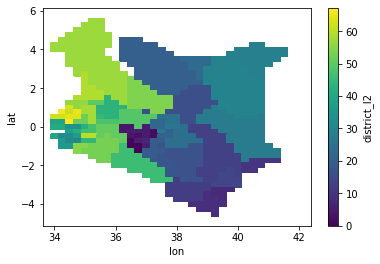

In [24]:
region_da.plot()

# Regional Performance


### Make region dataframe

In [25]:
import pickle

analyzer.analyze()

* Analyzing for district_l2_kenya *

** Analyzing for rnn-district_l2_kenya **
** Written rnn csv to data/analysis/region_analysis/rnn/rnn_district_l2_kenya.csv **

** Analyzing for linear_network-district_l2_kenya **
** Written linear_network csv to data/analysis/region_analysis/linear_network/linear_network_district_l2_kenya.csv **

** Analyzing for previous_month-district_l2_kenya **
** Written previous_month csv to data/analysis/region_analysis/previous_month/previous_month_district_l2_kenya.csv **

** Analyzing for ealstm-district_l2_kenya **
** Written ealstm csv to data/analysis/region_analysis/ealstm/ealstm_district_l2_kenya.csv **

** Analyzing for linear_regression-district_l2_kenya **
** Written linear_regression csv to data/analysis/region_analysis/linear_regression/linear_regression_district_l2_kenya.csv **
* Assigned all region dfs to `self.df` *

* Assigned Global Error Metrics to `self.global_mean_metrics` *
* Written csv to data/analysis/region_analysis/global_error_me

In [26]:
region_plotter = analyzer.create_model_performance_by_region_geodataframe()
df = analyzer.df
gdf = region_plotter.gdf

GroupbyRegion requires geopandas to be installed
Reading file: KEN_admin2_2002_DEPHA.shp
Reading file: Ken_Districts.shp
Reading file: Ken_Divisions.shp
Reading file: Kenya wards.shp
Reading file: Ken_Locations.shp
Reading file: Ken_Sublocations.shp
* Read shapefiles and stored in `RegionGeoPlotter.region_gdfs` *
* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


In [27]:
all_gdf = region_plotter.merge_all_model_performances_gdfs(analyzer.df)
all_gdf.head()

* Assigned the complete GeoDataFrame to `RegionGeoPlotter.gdf`


,admin_level_name,model,datetime,region_name,predicted_mean_value,true_mean_value,DISTNAME,geometry
0,district_l2_kenya,rnn,2016-01-31,VIHIGA,88.153908,80.547214,VIHIGA,POLYGON ((34.90335473150635 0.1988489371060185...
1,district_l2_kenya,ealstm,2016-01-31,VIHIGA,76.331573,80.547214,VIHIGA,POLYGON ((34.90335473150635 0.1988489371060185...
2,district_l2_kenya,previous_month,2016-01-31,VIHIGA,87.837838,80.547214,VIHIGA,POLYGON ((34.90335473150635 0.1988489371060185...
3,district_l2_kenya,linear_regression,2016-01-31,VIHIGA,42.042133,80.547214,VIHIGA,POLYGON ((34.90335473150635 0.1988489371060185...
4,district_l2_kenya,linear_network,2016-01-31,VIHIGA,63.365185,80.547214,VIHIGA,POLYGON ((34.90335473150635 0.1988489371060185...


## sklearn errors

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
districts = ["MARSABIT", "TURKANA", "WAJIR", "MANDERA"]

In [75]:
def calculate_r2(district_csv: pd.DataFrame, years: Optional[List[int]] = None) -> Dict[str, float]:
    relevant_districts = ['Mandera', 'Marsabit', 'Turkana', 'Wajir']
    assert len(district_csv.model.unique()) == 1, f"Expect ONE model. Got:{district_csv.model.unique()}"

    if years is None:
        years = [2016, 2017]  # to reflect the Adede paper

    district_csv["month"] = pd.to_datetime(district_csv.datetime).dt.month
    district_csv["year"] = pd.to_datetime(district_csv.datetime).dt.year
    
    # get years of interest
    data = district_csv[np.isin(district_csv.year, [2016, 2017])]
    
    output_dict: Dict[str: float] = {}
    
    # compute R2 for each district
    for district in relevant_districts:
        district_data = data.loc[data.region_name == district.upper()]
        if TARGET_VAR == 'boku_VCI':
            district_data = district_data.set_index('datetime').rolling(3, center=False).mean()
        
        district_data = district_data.dropna()
        district_score = r2_score(
            district_data.predicted_mean_value,
            district_data.true_mean_value
        )
        print(f'For {district}, r2 score: {district_score:.2f}')
        output_dict[district] = district_score
    return output_dict

print("EALSTM")
ealstm_dict = calculate_r2(district_csv=all_gdf.query("model == 'ealstm'"))
print("\nLSTM")
lstm_dict = calculate_r2(district_csv=all_gdf.query("model == 'rnn'"))

EALSTM
For Mandera, r2 score: 0.81
For Marsabit, r2 score: 0.72
For Turkana, r2 score: 0.91
For Wajir, r2 score: 0.69

LSTM
For Mandera, r2 score: 0.94
For Marsabit, r2 score: 0.88
For Turkana, r2 score: 0.92
For Wajir, r2 score: 0.88


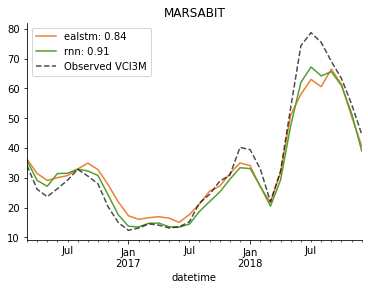

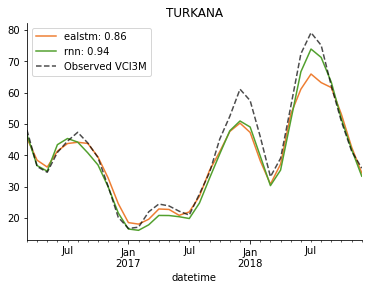

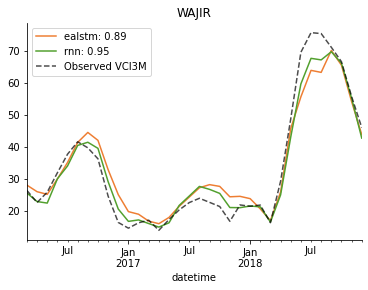

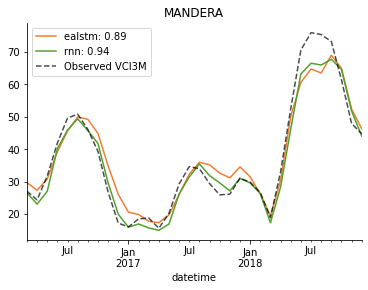

In [76]:
for district in districts:
    fig, ax = plt.subplots()
    
    for model in ['ealstm', 'rnn']:
        data = pd.DataFrame(
            (
                all_gdf
                .query(f"model == '{model}'")
                .loc[all_gdf.region_name == district.upper()]
            ).set_index('datetime').rolling(3, center=False).mean()
        ).dropna()

        r2 = r2_score(
                data.predicted_mean_value,
                data.true_mean_value
        )
        data['predicted_mean_value'].plot(
            ax=ax, 
            color='#ee7e33' if model == 'ealstm' else '#52a02e',
            label=f'{model}: {r2:.2f}'
        )
        
    data['true_mean_value'].plot(ax=ax, color='k', alpha=0.7, ls='--', label='Observed VCI3M')
    sns.despine()
    ax.set_title(f"{district}")
    ax.legend()

## Using the Spatial Masks on the error xr.Dataset objects

In [30]:
vci_r2s = [bline_r2.compute(), lr_r2.compute(), ln_r2.compute(), lstm_r2.compute(), ealstm_r2.compute()]

In [31]:
districts = ["MARSABIT", "TURKANA", "WAJIR", "MANDERA"]
district_keys = [k for k, v in region_lookup.items() if v in districts]

adede_mask = np.isin(region_da, district_keys)

district_masks = [region_da == key for key in district_keys]

In [32]:
# adede_rmses = [score.where(adede_mask) for score in vci3m_rmses]
adede_r2s = [
    [score.where(district_mask) for score in vci_r2s]
    for district_mask in district_masks
]
adede_r2s = [models[-2:] for models in adede_r2s]

In [33]:
# for ix, district in enumerate(districts):
#     lstm_results = adede_r2s[ix][0]
#     print(f"{district} LSTM R2:", f"{lstm_results.mean().values:.2f}")

# print()
# for ix, district in enumerate(districts):
#     ealstm_results = adede_r2s[ix][1]
#     print(f"{district} EALSTM R2:", f"{ealstm_results.mean().values:.2f}")

MARSABIT LSTM R2: 0.76
TURKANA LSTM R2: 0.76
WAJIR LSTM R2: 0.80
MANDERA LSTM R2: 0.71

MARSABIT EALSTM R2: 0.71
TURKANA EALSTM R2: 0.73
WAJIR EALSTM R2: 0.75
MANDERA EALSTM R2: 0.67


# Adede Comparison
- Need to calculate VCI3M to make comparisons

In [34]:
from src.analysis.indices.utils import rolling_mean

In [35]:
models_list = ["persistence", "linear_regression", "linear_network", "lstm", "ealstm"]
model_preds = [bline_pred.compute(), lr_pred.compute(), ln_pred.compute(), lstm_pred.compute(), ealstm_pred.compute()]

In [36]:
ROLLING_WINDOW = 1 if TARGET_VAR == "VCI3M" else 3

times = model_preds[0].time.values
vci3m_obs = rolling_mean(dynamic_ds[TARGET_VAR].sel(time=times), ROLLING_WINDOW).transpose("time", "lat", "lon")
vci3m_preds = [rolling_mean(p, ROLLING_WINDOW).transpose("time", "lat", "lon") for p in model_preds]

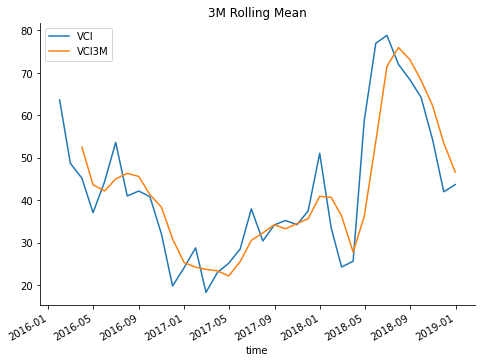

In [37]:
scale = 1.3
fig, ax = plt.subplots(figsize=(6*scale, 4*scale))

dynamic_ds[TARGET_VAR].sel(time=times).mean(dim=['lat', 'lon']).plot(ax=ax, label='VCI')
vci3m_obs.mean(dim=['lat', 'lon']).plot(ax=ax, label='VCI3M')
ax.set_title('3M Rolling Mean')

ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## model performance at 3M

In [38]:
from src.analysis import spatial_rmse, spatial_r2

vci3m_rmses = [
    spatial_rmse(
        vci3m_obs,
        vci3m_pred,
    )
    for vci3m_pred in vci3m_preds
]

vci3m_r2s = [
    spatial_r2(
        vci3m_obs,
        vci3m_pred,
    )
    for vci3m_pred in vci3m_preds
]

In [39]:
if TARGET_VAR == "boku_VCI":
    [
        print(f"{model} RMSE: {score.mean().values:.2f}")
        for model, score in zip(models_list, vci3m_rmses)
    ];
    print()
    [
        print(f"{model} R2: {score.mean().values:.2f}")
        for model, score in zip(models_list, vci3m_r2s)
    ];

persistence RMSE: 9.97
linear_regression RMSE: 22.53
linear_network RMSE: 17.86
lstm RMSE: 7.52
ealstm RMSE: 8.33

persistence R2: 0.78
linear_regression R2: 0.00
linear_network R2: 0.45
lstm R2: 0.87
ealstm R2: 0.85


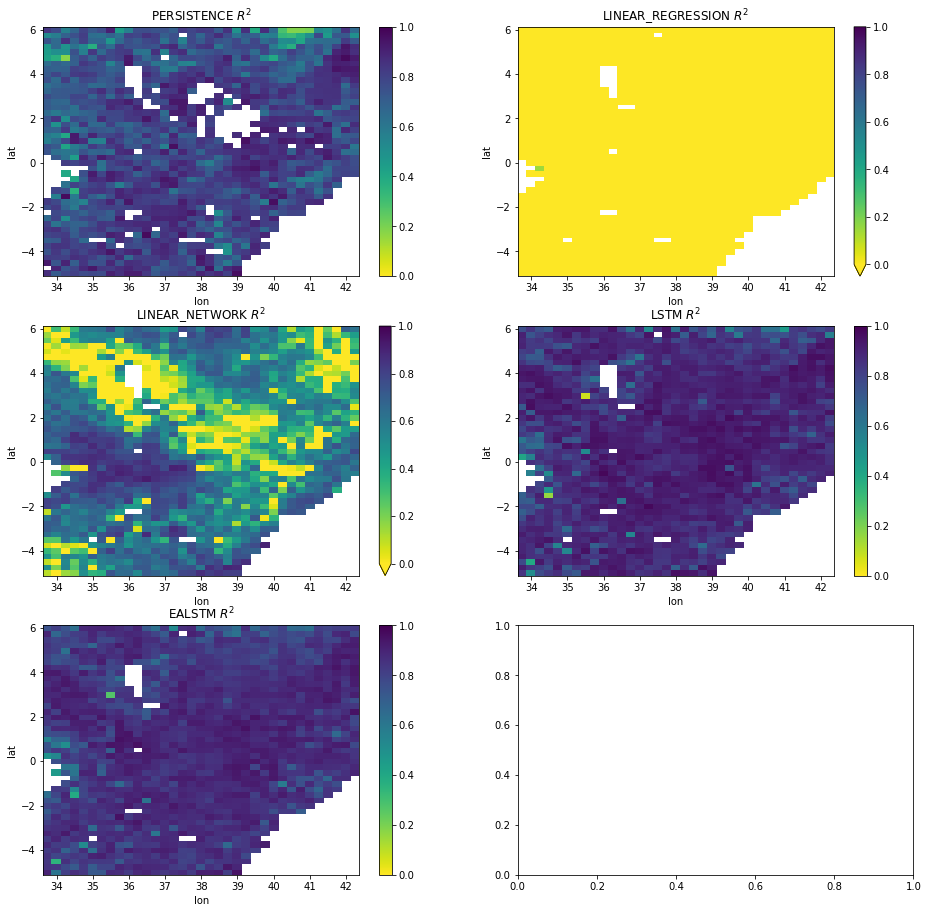

In [40]:
fig, axs = plt.subplots(3, 2, figsize=((6*2)*scale, (4*3)*scale))

ix = 0
model = models_list[ix]
score = vci3m_r2s[ix]
kwargs = dict(vmin=0, vmax=1, cmap='viridis_r')

for ix, (model, score) in enumerate(zip(models_list, vci3m_r2s)):
    ax = axs[np.unravel_index(ix, (3, 2))]
    score.plot(ax=ax, **kwargs)
    ax.set_title(f"{model.upper()} $R^2$")

# in the Test sites?

In [41]:
districts = ["MARSABIT", "TURKANA", "WAJIR", "MANDERA"]
district_keys = [k for k, v in region_lookup.items() if v in districts]

adede_mask = np.isin(region_da, district_keys)

district_masks = [region_da == key for key in district_keys]

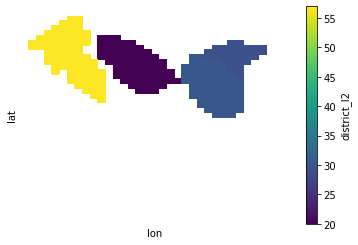

In [42]:
fig, ax = plt.subplots()
region_da.where(adede_mask).plot(ax=ax)
# region_da.where(district_masks[0]).plot(ax=ax)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

In [43]:
# adede_rmses = [score.where(adede_mask) for score in vci3m_rmses]
adede_r2s = [
    [score.where(district_mask) for score in vci3m_r2s]
    for district_mask in district_masks
]
adede_r2s = [models[-2:] for models in adede_r2s]

In [44]:
for ix, district in enumerate(districts):
    lstm_results = adede_r2s[ix][0]
    ealstm_results = adede_r2s[ix][1]
    print(f"{district} LSTM R2:", f"{lstm_results.mean().values:.2f}")
    print(f"{district} EALSTM R2:", f"{ealstm_results.mean().values:.2f}")

MARSABIT LSTM R2: 0.88
MARSABIT EALSTM R2: 0.86
TURKANA LSTM R2: 0.90
TURKANA EALSTM R2: 0.88
WAJIR LSTM R2: 0.91
WAJIR EALSTM R2: 0.89
MANDERA LSTM R2: 0.86
MANDERA EALSTM R2: 0.83


## Scatter / Time series plots

In [45]:
# from scripts.drafts.plot_ts_scatter import plot_area_scatter, plot_timeseries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict, Any, List

def plot_area_scatter(
    df: pd.DataFrame, 
    region: str,
    metrics_df: Optional[pd.DataFrame] = None, 
    ax=None,
    target_var: str = TARGET_VAR,
    region_name: Optional[str] = None,
    area_col_str: str = 'region_name',
    **kwargs,
):
    # select station
    d = df.query(f"{area_col_str} == '{region}'").drop(columns=area_col_str)

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    else:
        fig = plt.gcf()

    # plot scatter
    if "preds" in d.columns:
        ax.plot(d[target_var], d['preds'], 'kx', alpha=0.6, label='Data Point', **kwargs)
    else:
        numeric_columns = [c for c in data_df.columns if (data_df[c].dtype == "float64") & (c != TARGET_VAR)]
        colors = sns.color_palette()[:len(numeric_columns)]
        for numeric_col, color in zip(numeric_columns, colors):
            ax.plot(d[target_var], d[numeric_col], 'kx', alpha=0.6, label=f'{numeric_col}', color=color, **kwargs)
    # plot 1:1 line
    line_1_1_x = np.linspace(d[target_var].min(), d[target_var].max(), 10)
    ax.plot(line_1_1_x, line_1_1_x, 'k--', label='1:1 Line')

    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted')
    title = f'Station {region}' + f" {region_name}" if region_name is not None else f'Station {region}'
    ax.set_title(title)

    ax.legend();

    if False:
        # making the plot pretty
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                          + ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(12)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, ax


def plot_timeseries(
    df: pd.DataFrame,
    region: str,
    metrics_df: Optional[pd.DataFrame] = None,
    ax=None,
    region_name: Optional[str] = None,
    plot_years: Optional[List[int]] = None,
    area_col_str: str = 'region_name',
    plot_target: bool = False,
):
    """Plot the Observed vs. Preds for the region"""
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    # plot the station
    drop_cols = [area_col_str] if plot_target else [area_col_str, TARGET_VAR]
    if "preds" in df.columns:
        if plot_years is None:
            df.query(f"{area_col_str} == '{region}'").drop(columns=drop_cols).plot(ax=ax)
        else:
            (
                df.loc[np.isin(df.index.year, plot_years)]
                .query(f"{area_col_str} == '{region}'")
                .drop(columns=drop_cols).plot(ax=ax)
            )
    else:
        if plot_years is None:
            df.query(f"{area_col_str} == '{region}'")[TARGET_VAR].plot(ax=ax, )
            df.query(f"{area_col_str} == '{region}'").drop(columns=[area_col_str, TARGET_VAR]).plot(ax=ax)
        else:
            (
                df.loc[np.isin(df.index.year, plot_years)]
                .query(f"{area_col_str} == '{region}'")
                .drop(columns=area_col_str).plot(ax=ax)
            )
                
    # get the error metrics
    if metrics_df is None:
        station_title = f"{region}" if region_name is not None else region
        ax.set_title(f"{station_title}")
    else:
        rmse_val = metrics_df.query(f"region == '{region}'").rmse.values[0]
        r2_val = metrics_df.query(f"region == '{region}'").r2.values[0]
        # nse_val = metrics_df.query(f"region == '{region}'").nse.values[0]
        # set the title
        station_title = f"{region} {region_name}" if region_name is not None else region
        ax.set_title(f"{station_title}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f} NSE: {nse_val:.2f}")

    return fig, ax


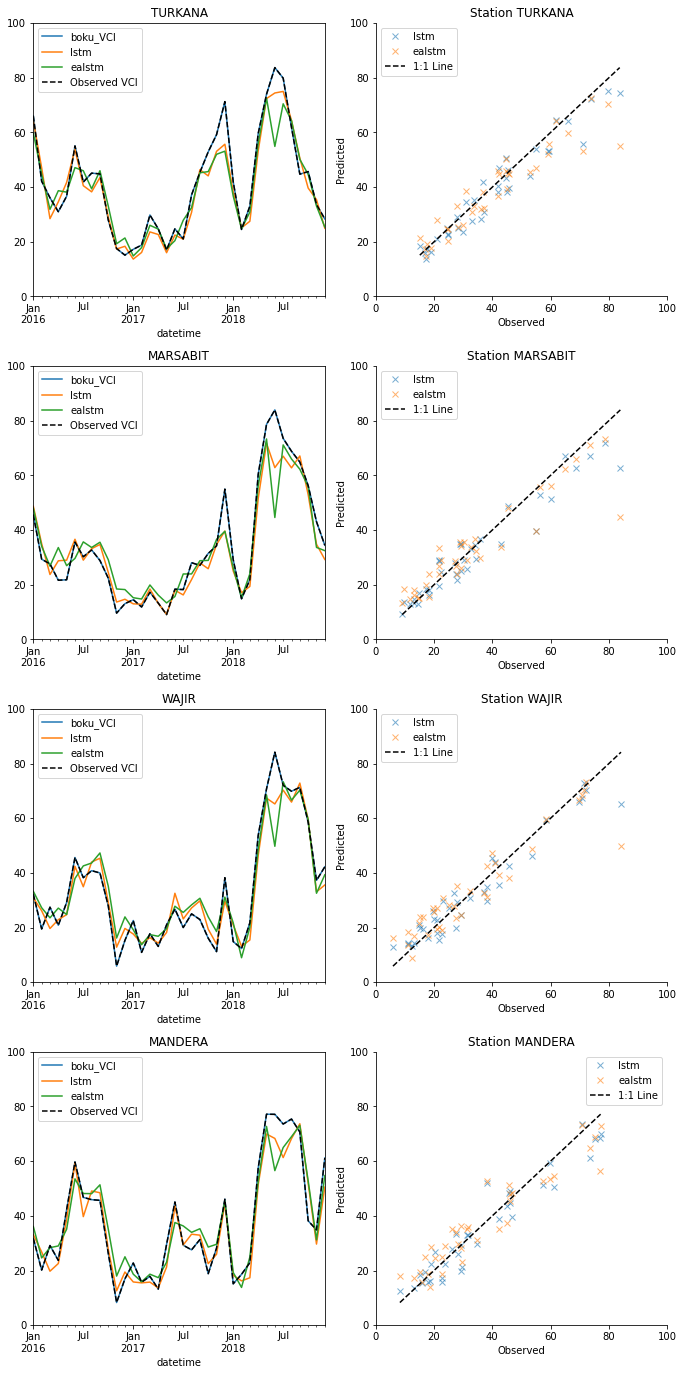

In [46]:
# regions = all_gdf.region_name.unique()
data_df = df.copy().set_index("datetime")
data_df = data_df.rename(columns={"true_mean_value": TARGET_VAR, "predicted_mean_value": "preds"}).drop(columns=["admin_level_name"])

m1 = data_df.reset_index().set_index(['datetime', 'region_name']).query('model == "rnn"').rename(columns={"preds": "lstm"}).drop(columns=['model'])
m2 = data_df.reset_index().set_index(['datetime', 'region_name']).query('model == "ealstm"').rename(columns={"preds": "ealstm"})
m2 = m2.drop(columns=['model', TARGET_VAR])
data_df = m1.join(m2).reset_index().set_index('datetime')

regions = ["TURKANA", "MARSABIT", "WAJIR", "MANDERA"]
# model = 'ealstm'
plot_years = None # [2016]
scale = 0.8
fig, axs = plt.subplots(len(regions), 2, figsize=((12*scale), (6*scale)*len(regions)))

for ix, region in enumerate(regions):
    try:
        # plot the timeseries
        plot_timeseries(
            data_df,# .drop(columns=TARGET_VAR),  # data_df.query(f"model == '{model}'"), 
            region, 
            metrics_df=None, 
            ax=axs[ix, 0], 
            region_name=region, 
            plot_years=plot_years,
            plot_target=False,
            
        )
        data_df.query(f"region_name=='{region}'")[TARGET_VAR].plot(ax=axs[ix, 0], c='k', label='Observed VCI', ls='--')
        axs[ix, 0].set_ylim(0, 100)
        axs[ix, 0].legend()
        
        # plot the scatterplot
        plot_area_scatter(
            data_df,  # data_df.query(f"model == '{model}'"), 
            region, 
            metrics_df=None, 
            ax=axs[ix, 1]
        )
        axs[ix, 1].set_xlim(0, 100)
        axs[ix, 1].set_ylim(0, 100)
    except TypeError:
        print(f"** {region_name} data does not exist in the predictions! **")

    plt.tight_layout()